## 음성을 이미지로 변환


음성에 멜 필터뱅크를 적용하여 이미지로 변환함으로서 CNN에 직접적으로 적용할 수 있도록 음성 파일을 변환함.


In [1]:
# Load packages
import os
import sys
import wave
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
import matplotlib.pyplot as plt
from uuid import uuid4

In [2]:
target_animal = 'dog'  # 'cat', 'dog'

# Set Path
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'data', target_animal)
image_data_path = os.path.join(main_path, 'image_data', target_animal)

sys.path.append(main_path)

if not os.path.exists(image_data_path):
    os.makedirs(image_data_path)
if not os.path.exists(data_path):
    os.makedirs(data_path)

state_list = [dir_path for dir_path in os.listdir(data_path) if os.path.isdir(
    os.path.join(data_path, dir_path))]
state_list

['relax', 'hostile', 'whining']

In [3]:
# 데이터 경로를 불러오는 함수를 정의한다.
def get_sound_files_by_state(target_path, state_list):
    sound_files = {}
    for state in state_list:
        sound_files[state] = []

    for (root, dir, files) in os.walk(target_path):
        folder_state = root.split('/')[-1]
        if folder_state not in state_list:
            continue
        for file in files:
            if file.endswith('.wav'):
                sound_files[root.split(
                    '/')[-1]].append(os.path.join(root, file))
    return sound_files


origin_sound_files = get_sound_files_by_state(data_path, state_list)
for state in state_list:
    print(
        f'{state}: {len(origin_sound_files[state])}', origin_sound_files[state][:2])

relax: 151 ['/Users/jaewone/Downloads/FurEmotion-AI/data/dog/relax/relax_129.wav', '/Users/jaewone/Downloads/FurEmotion-AI/data/dog/relax/relax_115.wav']
hostile: 151 ['/Users/jaewone/Downloads/FurEmotion-AI/data/dog/hostile/hostile_139.wav', '/Users/jaewone/Downloads/FurEmotion-AI/data/dog/hostile/hostile_111.wav']
whining: 167 ['/Users/jaewone/Downloads/FurEmotion-AI/data/dog/whining/whining_17.wav', '/Users/jaewone/Downloads/FurEmotion-AI/data/dog/whining/whining_1.wav']


## 음성 길이와 주파수 통일


자르는 과정에서 정확하게 2초가 아닌 1.98초와 같이 정확하게 시간이 맞추어지지 않는 경우가 있다. 이에 음성 앞뒤에 padding을 추가하여 정확하게 2초로 맞추어준다. 이때, padding은 0으로 채워준다.


In [4]:
import os
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm


def pad_wav_files(sound_data_path, sampling_rate=16000, duration=2.0):
    all_files = os.listdir(sound_data_path)
    wav_files = [f for f in all_files if f.lower().endswith('.wav')]

    for i in tqdm(range(len(wav_files))):
        file_path = os.path.join(sound_data_path, wav_files[i])
        try:
            file_sampling_rate, data = wavfile.read(file_path)
            if file_sampling_rate != sampling_rate:
                print(
                    f"File '{wav_files[i]}' has a different sampling rate ({file_sampling_rate} Hz). Skipping.")
                continue

            target_length = int(duration * sampling_rate)
            current_length = data.shape[0]

            if current_length < target_length:
                padding_needed = target_length - current_length
                padding_left = padding_needed // 2
                padding_right = padding_needed - padding_left

                if data.ndim == 1:
                    # Mono channel
                    padded_data = np.pad(
                        data, (padding_left, padding_right), mode='constant', constant_values=0)
                else:
                    # Multi-channel (e.g., stereo)
                    padded_data = np.pad(
                        data, ((padding_left, padding_right), (0, 0)), mode='constant', constant_values=0)

                wavfile.write(file_path, sampling_rate, padded_data)
            elif current_length > target_length:
                # Trim the excess if longer than desired duration
                trimmed_data = data[:target_length]
                wavfile.write(file_path, sampling_rate, trimmed_data)
            else:
                # Already the desired duration
                pass
        except Exception as e:
            print(f"Could not process '{wav_files[i]}': {e}")


def check_wav_files(sound_data_path, sampling_rate=16000, duration=2.0):
    all_files = os.listdir(sound_data_path)
    wav_files = [f for f in all_files if f.lower().endswith('.wav')]
    all_ok = True

    for i in tqdm(range(len(wav_files))):
        file_path = os.path.join(sound_data_path, wav_files[i])
        try:
            file_sampling_rate, data = wavfile.read(file_path)
            file_duration = len(data) / file_sampling_rate
            if file_sampling_rate != sampling_rate or abs(file_duration - duration) > 0.01:
                print(f"File '{wav_files[i]}' does not meet the criteria.")
                print(
                    f"Sampling rate: {file_sampling_rate}, Duration: {file_duration:.2f} seconds")
                all_ok = False
        except Exception as e:
            print(f"Could not read file '{wav_files[i]}': {e}")
            all_ok = False

    if all_ok:
        print(
            f"All files have a duration of {duration} seconds and a sampling rate of {sampling_rate} Hz.")
    else:
        print("Some files do not meet the criteria.")


for state in state_list:
    state_path = os.path.join(data_path, state)
    print(f"\nPadding files in '{state}'")
    pad_wav_files(state_path)

    print(f"\nChecking files in '{state}'")
    check_wav_files(state_path)


Padding files in 'relax'


100%|██████████| 151/151 [00:00<00:00, 2730.45it/s]



Checking files in 'relax'


100%|██████████| 151/151 [00:00<00:00, 29912.62it/s]


All files have a duration of 2.0 seconds and a sampling rate of 16000 Hz.

Padding files in 'hostile'


100%|██████████| 151/151 [00:00<00:00, 2768.82it/s]



Checking files in 'hostile'


100%|██████████| 151/151 [00:00<00:00, 28241.32it/s]


All files have a duration of 2.0 seconds and a sampling rate of 16000 Hz.

Padding files in 'whining'


100%|██████████| 167/167 [00:00<00:00, 2916.26it/s]



Checking files in 'whining'


100%|██████████| 167/167 [00:00<00:00, 30046.70it/s]

All files have a duration of 2.0 seconds and a sampling rate of 16000 Hz.


## 이미지로 변환 후 저장


분석을 용이하게 하기 위해 이미지로 변환한 후 저장한다.


In [5]:
import os
import numpy as np
import librosa
from skimage.transform import resize
from PIL import Image


def convert_wav_to_image(file_path: str) -> np.ndarray:
    """
    Converts a WAV file to a mel spectrogram image.

    Parameters:
    file_path (str): Path to the WAV file.

    Returns:
    np.ndarray: A 3D numpy array representing the image.
    """
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
    mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
    RATIO = 862 / 64
    mel_spec_dB_resized = resize(
        mel_spec_dB,
        (mel_spec_dB.shape[0], int(mel_spec_dB.shape[1] * RATIO)),
        anti_aliasing=True,
        mode='reflect'
    )
    mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
    return mel_spec_dB_stacked


def save_spectrogram_image(mel_spec: np.ndarray, save_path: str):
    """
    Saves the mel spectrogram as an image file.

    Parameters:
    mel_spec (np.ndarray): The mel spectrogram array.
    save_path (str): Path where the image will be saved.
    """
    # Normalize the spectrogram to the range [0, 255]
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    mel_spec *= 255.0
    mel_spec = mel_spec.astype(np.uint8)

    # Convert to PIL Image and save
    image = Image.fromarray(mel_spec)
    image.save(save_path)


for state in state_list:
    state_sound_path = os.path.join(data_path, state)
    state_image_path = os.path.join(image_data_path, state)
    os.makedirs(state_image_path, exist_ok=True)

    wav_files = [f for f in os.listdir(
        state_sound_path) if f.lower().endswith('.wav')]

    print(f"\nStart processing '{state}'")
    for i in tqdm(range(len(wav_files))):
        wav_file_path = os.path.join(state_sound_path, wav_files[i])
        image_file_name = os.path.splitext(wav_files[i])[0] + '.png'
        image_file_path = os.path.join(state_image_path, image_file_name)

        try:
            mel_spec_image = convert_wav_to_image(wav_file_path)
            save_spectrogram_image(mel_spec_image, image_file_path)
        except Exception as e:
            print(f"Could not process '{wav_files[i]}': {e}")


Start processing 'relax'


  1%|          | 1/151 [00:00<01:33,  1.60it/s]/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_67597/4012959364.py:43: RuntimeWarning: invalid value encountered in divide
  mel_spec /= mel_spec.max()
/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_67597/4012959364.py:45: RuntimeWarning: invalid value encountered in cast
  mel_spec = mel_spec.astype(np.uint8)
100%|██████████| 151/151 [00:05<00:00, 26.52it/s]



Start processing 'hostile'


100%|██████████| 151/151 [00:04<00:00, 31.55it/s]



Start processing 'whining'


100%|██████████| 167/167 [00:04<00:00, 40.84it/s]


/Users/jaewone/Downloads/FurEmotion-AI/image_data/dog/relax/relax_97.png


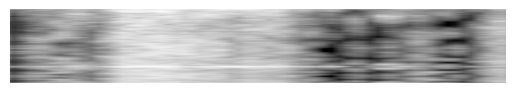

(128, 862, 3)

In [ ]:
random_file = np.random.choice([file for file in os.listdir(
    os.path.join(image_data_path, state_list[0])) if file.endswith('.png')])
test_file_path = os.path.join(image_data_path, state_list[0], str(random_file))
print(test_file_path)


# display image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


display_image(test_file_path)

# print image shape
image = Image.open(test_file_path)
image_array = np.array(image)
image_array.shape